## Библиотеки, параметры, константы задачи

In [1]:
from applications.poly_features_environment import PolyFeaturesEnv
import torch
import models
import numpy as np
from common.fstream import read_tensor, read_matrix, rescale_array, read_mc_tensor

PATH_BASE = "/home/amedvedev/projects/python/DenoisingCNN"
NAME_DATASET = "gcg19"
env = PolyFeaturesEnv(name_model="uvych_matrix_denoiser_21_im", 
                      name_dataset=NAME_DATASET, 
                      path_base=PATH_BASE,
                      device_name="cuda")


In [8]:
env.train_target_loader[0][0].shape


torch.Size([1, 80, 80])

## Загрузка данных

In [3]:
import torchvision
from scipy import fftpack

def fft2d_transform(path):
    x = read_matrix(path)
    #x = torch.tensor(read_matrix(path), dtype=torch.float)
    # fft2 = torch.fft.fft2(x, norm="ortho")
    # res = torch.dstack([fft2.real, fft2.imag]).permute([2, 0, 1])
    # return res.detach().numpy()
    
    t =  np.log(fftpack.fftshift( fftpack.fft2(x) ))
    return t.real #np.dstack([t.real, t.imag])
# t =  np.log(fftpack.fftshift( fftpack.fft2(x)))

env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=4, val_batch_size=4
    ) \
    .load_feature(
        shape=(1, 80, 80), feature_name="Uvych2_noised_re.xls", mapper=fft2d_transform, transform=None, lazy_load=False
    ) \
    .set_target(
        shape=(1, 80, 80), target_name="Uvych2_re.xls", mapper=fft2d_transform, transform=None, lazy_load=False
    ) \

print(env.train_count, env.val_count)

223 16oading progress: |██████████████████████████████████████████████----| 93.8% Complete | 


In [2]:
from scipy import fftpack

def get_noised(uvych, pct):
    uvych_noised = uvych.copy()
    for i in range(len(uvych)):
        for j in range(len(uvych[i])):
            ppp = np.random.uniform(low=0, high=pct)
            uvych_noised[i][j] *= (1 + ppp)
                    
    return uvych_noised

def f(x):
    return fftpack.fftshift(fftpack.fft2(x)) # np.log(fftpack.fft2(x))


def preprocess(path):
    data = read_matrix(path)
    step_pct = 0.001
    k = 5
    psd2D_noised = sum([f(get_noised(data, step_pct)) for _ in range(k)]) / k
    return np.stack([psd2D_noised.real, psd2D_noised.imag])

def preprocess2(path):
    data = read_matrix(path)
    psd2D = f(data)
    return np.stack([psd2D.real, psd2D.imag])
    
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=16, val_batch_size=4
    ) \
    .load_feature(
        shape=(2, 80, 80), feature_name="Uvych2_re.xls", mapper=preprocess, transform=None
    ) \
    .set_target(
        shape=(2, 80, 80), target_name="Uvych2_re.xls", mapper=preprocess, transform=None
    ) \

print(env.train_count, env.val_count)

27 16loading progress: |██████████████████████████████████████████████----| 93.8% Complete | 


In [2]:
from scipy import fftpack

def get_noised(uvych, pct):
    uvych_noised = uvych.copy()
    for i in range(len(uvych)):
        for j in range(len(uvych[i])):
            ppp = np.random.uniform(low=0, high=pct)
            uvych_noised[i][j] *= (1 + ppp)
                    
    return uvych_noised

def f(x):
    return fftpack.fftshift(fftpack.fft2(x)) # np.log(fftpack.fft2(x))


def preprocess(path):
    data = read_matrix(path)
    step_pct = 0.001
    k = 5
    psd2D = f(data)
    psd2D_noised = sum([f(get_noised(data, step_pct)) for _ in range(k)]) / k
    return (psd2D.imag - psd2D_noised.imag).ravel()

def preprocess2(path):
    data = read_matrix(path)
    psd2D = f(data)
    return psd2D.imag.ravel()
    
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=16, val_batch_size=4
    ) \
    .load_feature(
        shape=(80 * 80,), feature_name="Uvych2_re.xls", mapper=preprocess, transform=None
    ) \
    .set_target(
        shape=(80 * 80,), target_name="Uvych2_re.xls", mapper=preprocess, transform=None
    ) \

print(env.train_count, env.val_count)

55 16loading progress: |██████████████████████████████████████████████----| 93.8% Complete | 


In [ ]:
from scipy import fftpack

def get_noised(uvych, pct):
    uvych_noised = uvych.copy()
    for i in range(len(uvych)):
        for j in range(len(uvych[i])):
            ppp = np.random.uniform(low=0, high=pct)
            uvych_noised[i][j] *= (1 + ppp)
                    
    return uvych_noised

def f(x):
    return fftpack.fftshift(fftpack.fft2(x)) # np.log(fftpack.fft2(x))


def preprocess(path):
    data = read_matrix(path)
    step_pct = 0.001
    k = 1
    psd2D = f(data)
    psd2D_noised = sum([f(get_noised(data, step_pct)) for _ in range(k)]) / k
    return np.concatenate([(psd2D.real - psd2D_noised.real).ravel(), (psd2D.imag - psd2D_noised.imag).ravel()])

def preprocess2(path):
    data = read_matrix(path)
    psd2D = f(data)
    return np.concatenate([psd2D.real.ravel(), psd2D.imag.ravel()])
    
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=16, val_batch_size=4
    ) \
    .load_feature(
        shape=(2 * 80 * 80,), feature_name="Uvych2_re.xls", mapper=preprocess, transform=None
    ) \
    .set_target(
        shape=(2 * 80 * 80,), target_name="Uvych2_re.xls", mapper=preprocess, transform=None
    ) \

print(env.train_count, env.val_count)

In [2]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=32, val_batch_size=4
    ) \
    .load_feature(
        shape=(1, 80, 80), feature_name="Uvych2_noised_re_rotated.xls", mapper=read_matrix, transform=None
    ) \
    .set_target(
        shape=(1, 80, 80), target_name="Uvych2_re_rotated.xls", mapper=lambda path: read_matrix(path), transform=None
    ) \

print(env.train_count, env.val_count)

27 16loading progress: |██████████████████████████████████████████████----| 93.8% Complete | 


In [22]:
t = env.train_target_loader[0][2]
t

tensor([-0.0267, -0.0605,  0.0110,  ..., -0.0126, -0.0457, -0.0345],
       device='cuda:0')

In [17]:
orig = torch.fft.ifft2(fft2, norm="ortho")

In [3]:
import matplotlib.pyplot as plt
im = plt.imshow(orig.imag.cpu().detach().numpy())
plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)


NameError: name 'orig' is not defined

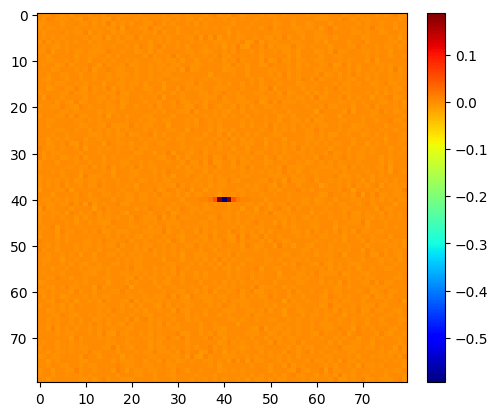

In [3]:
import matplotlib.pyplot as plt
im = plt.imshow(env.train_features_loaders[0][0][0][0].cpu().detach().numpy() - env.train_target_loader[0][0][0].cpu().detach().numpy(), cmap="jet")
plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)


## Модели

### Новая локальная модель

In [29]:
env.set_name_model("uvych_matrix_noise_predictor_2")

In [3]:
env.model = models.autoencoders.UnetAutoencoder.UNetAuto(num_channels=1, num_out_channels=1).to(env.device)

In [26]:
env.model = models.autoencoders.unet.UNet(in_channels=1, out_channels=1, init_features=64).to(env.device)


In [14]:
env.model = models.autoencoders.purecnns.ConvAutoencoderLumaRelu9(in_channels=1, out_channels=1).to(env.device)


In [3]:
env.model = models.autoencoders.res_unet.ResUnetPlusPlus(channel=1).to(env.device)

In [7]:
env.model = models.autoencoders.residual.AEv6_0(in_channels=2, out_channels=2).to(env.device)
# fm_path="/home/amedvedev/projects/python/DenoisingCNN/assets/pt/uvych_matrix_denoiser_10 (4th copy).pt"
from torch import nn


In [4]:
env.model = models.predictors.NoiseMatrixPredictor_v1(1, 1, 80, 80, 80 * 80).to(env.device)

In [13]:
env.model = models.autoencoders.wavelet.WMDCNN(1, 4, 4, 28).to(env.device)

In [3]:
from torch import nn
class UvychDimExpand(nn.Module):
    def __init__(self, size, hidden_sizes):
        super(UvychDimExpand, self).__init__()
        
        self.size = size
        self.hidden_sizes = hidden_sizes

        self.layers = nn.ModuleList(
            [
                nn.Linear(size, hidden_sizes[0]),
                nn.LeakyReLU()
            ]
            +
            [
                nn.Sequential(
                    nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]),
                    nn.LeakyReLU()

                )
                for i in range(1, len(hidden_sizes))
            ]
            +
            [
                nn.Linear(hidden_sizes[-1], size)
            ]
        )


    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x



In [4]:
env.model = UvychDimExpand(2 * 80 * 80, [2 * 80 * 80, 2 * 80 * 80]).to(env.device)
env.model 


UvychDimExpand(
  (layers): ModuleList(
    (0): Linear(in_features=12800, out_features=12800, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Sequential(
      (0): Linear(in_features=12800, out_features=12800, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (3): Linear(in_features=12800, out_features=12800, bias=True)
  )
)

In [4]:
env.model = UvychDimExpand(80 * 80, [80 * 80, 80 * 80]).to(env.device)
env.model 


UvychDimExpand(
  (layers): ModuleList(
    (0): Linear(in_features=6400, out_features=6400, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Sequential(
      (0): Linear(in_features=6400, out_features=6400, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (3): Linear(in_features=6400, out_features=6400, bias=True)
  )
)

In [5]:
from torch import nn
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
    elif isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_normal_(m.weight.data)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data)
        # nn.init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, mean=1, std=0.02)
        nn.init.constant_(m.bias.data, 0)

env.model.apply(weights_init)

UvychDimExpand(
  (layers): ModuleList(
    (0): Linear(in_features=6400, out_features=6400, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Sequential(
      (0): Linear(in_features=6400, out_features=6400, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (3): Linear(in_features=6400, out_features=6400, bias=True)
  )
)

In [22]:
env.model = models.autoencoders.swin_unet.SwinTransformerSys(64, in_chans=1, num_classes=1, window_size=4).to(env.device)


SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:1
---final upsample expand_first---


In [4]:
env.model

AEv4_0(
  (first): AEv2_0(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_transpose0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_transpose1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_transpose2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_transpose3): ConvTranspose2d(64, 64, k

### Импорт претренерованной модели

In [ ]:
env.model()

In [19]:
env.load_model(model_type="pt")

## Визуализация батча валидационного датасета

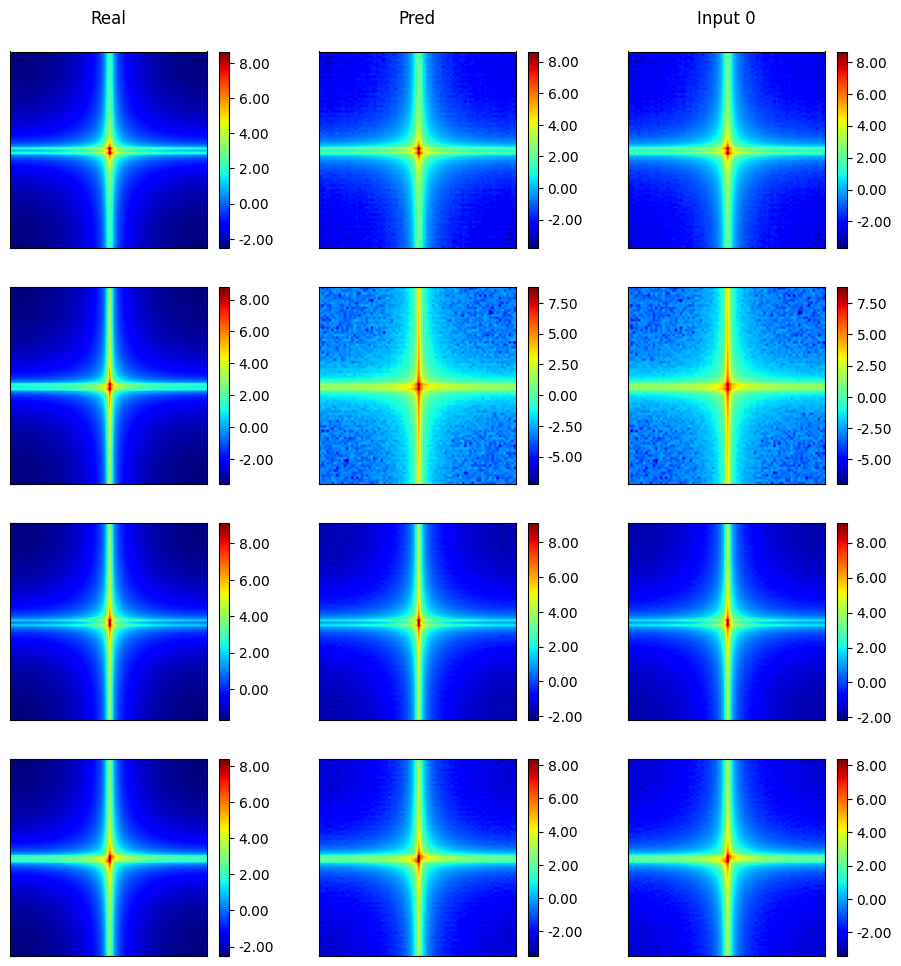

In [14]:
env.plot_batch_with_inputs(concrete=0, figsize=(10, 10), format="%.2f", wspace=0.0, hspace=0.2)


In [15]:
env.val_target_loader[3][0].shape

torch.Size([12800])

[ 6.2450043e-18 -1.2312910e-02  8.1860349e-03 ...  4.4027213e-03
  3.0550834e-02 -2.6830085e-02]
[ 0.01457978  0.02254123 -0.00514973 ...  0.01113575 -0.00824788
  0.02570205]
[ 6.9388940e-19  2.7661573e-02  2.0805271e-02 ...  1.4399553e-02
 -4.5274636e-03 -1.7831847e-02]
[ 0.01034761  0.00979582 -0.00489299 ... -0.00563732  0.00372986
  0.00929517]
[ 8.89045761e-19 -5.78608131e-03 -1.00622475e-02 ...  4.58165864e-03
 -1.49875600e-02 -8.62412248e-03]
[ 0.00016182 -0.00492567  0.00175513 ... -0.00103463  0.00571849
  0.00204236]
[-1.1102230e-17  4.2121857e-03  1.2442600e-02 ...  3.4331146e-03
  1.6118707e-03 -4.1972939e-03]
[ 0.01004505 -0.00066477 -0.01702356 ...  0.01372662 -0.01076349
 -0.00444987]


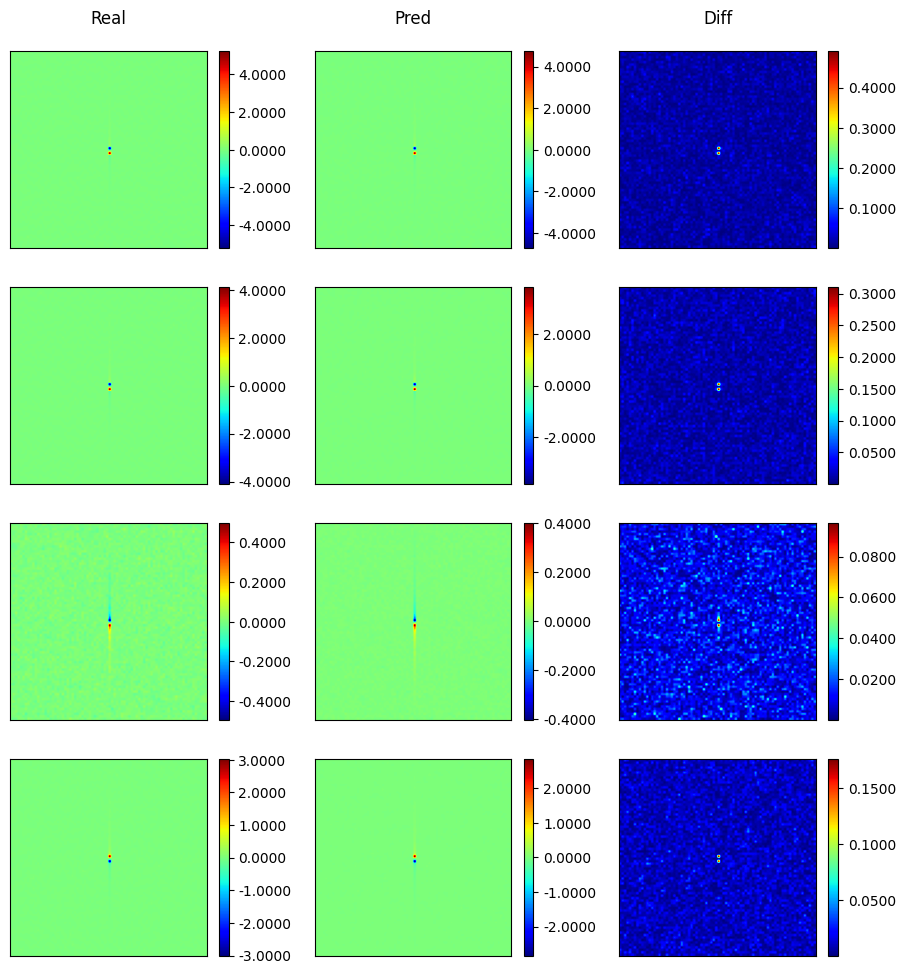

In [14]:
env.plot_batch(concrete=5, figsize=(10, 10), format="%.4f", wspace=0.0, hspace=0.2, size=[80 * 80],
               func_postprocess=lambda x: x.reshape(80, 80))


In [7]:
env.model

AEv6_0(
  (conv0): Conv2d(1, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv_transpose0): ConvTranspose2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv_transpose1): ConvTranspose2d(80, 80, kern

## Численные значения отклонений

In [13]:
def test():
    losses = []
    errors = []
    init_errors = []
    losses_dataset = []
    with torch.no_grad():
    
        for row in zip(*env.val_features_loaders + [env.val_target_loader]):
            data_features = list(row)
            data_target = data_features.pop()
            outputs = env.model(*data_features) #* 65.

        
            
            for ex_id in range(env.val_batch_size):

                losses_dataset_step = torch.max(torch.abs(data_features[0][ex_id] - data_target[ex_id])).detach().tolist()
                losses_dataset.append(losses_dataset_step)
                
                init_error = torch.mean(torch.abs(data_features[0][ex_id] - data_target[ex_id]) / torch.abs(data_target[ex_id]))
                init_errors.append(init_error.detach().tolist())

                loss = torch.max(torch.abs(outputs[ex_id] - data_target[ex_id]))
                losses.append(loss.detach().tolist())
                # print(data_target[ex_id].size())


                error = torch.mean(torch.abs(outputs[ex_id] - data_target[ex_id]) / torch.abs(data_target[ex_id]))
                errors.append(error.detach().tolist())
                
    print("Начальное среднее отклонение по значениям:", sum(losses_dataset) / len(losses_dataset))
    print("Текущее среднее отклонение по значениям:", sum(losses) / len(losses))
    
    print()
    print("Начальное максимальное отклонение по значениям:", max(losses_dataset))
    print("Текущее максимальное отклонение по значениям в векторе:", max(losses))
    
    # print()
    # print("Начальная средняя относительная ошибка:", sum(init_errors) / len(init_errors))
    # print("Текущая средняя относительная ошибка:", sum(errors) / len(errors))
    # print()
    # print("Начальная максимальная относительная ошибка:", max(init_errors))
    # print("Текущая максимальная относительная ошибка:", max(errors))
test()

Начальное среднее отклонение по значениям: 0.06916807743255049
Текущее среднее отклонение по значениям: 0.19298681715736166

Начальное максимальное отклонение по значениям: 0.21478959918022156
Текущее максимальное отклонение по значениям в векторе: 0.49213504791259766


## Training

In [18]:
from common.losses import MseCoeffLoss, L1CoeffLoss
from pytorch_msssim import MS_SSIM as _MS_SSIM


In [24]:
env.set_name_model("uvych_tensor_denoiser_2")

In [13]:
opt = torch.optim.AdamW(env.model.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[int(10 * 0.6), int(10 * 0.9)], gamma=0.1)

In [16]:
class L1_MSSSIM(torch.nn.Module):
    def __init__(self):
        super(L1_MSSSIM, self).__init__()
        self.l1 = nn.L1Loss()
        self.ms_ssim = _MS_SSIM(data_range=4, size_average=True, win_size=1, channel=1)

    def forward(self, x, y):
        ms_ssim_loss = 1 - self.ms_ssim(x, y)
        l1_loss = self.l1(x, y)

        return l1_loss + ms_ssim_loss

In [12]:
from torch import nn

In [99]:
env.train(5, step_saving=True, step_plotting=False,
          optimizer=opt, scheduler=None, 
          criterion=L1_MSSSIM().to(env.device), 
          callbacks=[lambda: scheduler.step()]) #


NameError: name 'L1_MSSSIM' is not defined

In [8]:
opt = torch.optim.Adam(env.model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=4)
# scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)



In [19]:
import gc
gc.collect()

0

In [12]:
env.train(5, step_saving=True, step_plotting=False,
          optimizer=opt, scheduler=None, 
          criterion=torch.nn.SmoothL1Loss(),
          callbacks=[lambda: scheduler.step(env.test_losses[-1])]) #lambda: scheduler.step(env.test_losses[-1])

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 1 	Training Loss: 0.000098761 	Validating Loss: 0.000129527 	Time: 0.20 m


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 2 	Training Loss: 0.000095771 	Validating Loss: 0.000129234 	Time: 0.18 m


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 3 	Training Loss: 0.000092644 	Validating Loss: 0.000128928 	Time: 0.18 m


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 
Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 4

## Сохранение модели

In [10]:
env.save(onnx=False, pth=False)

## Loss visualisation

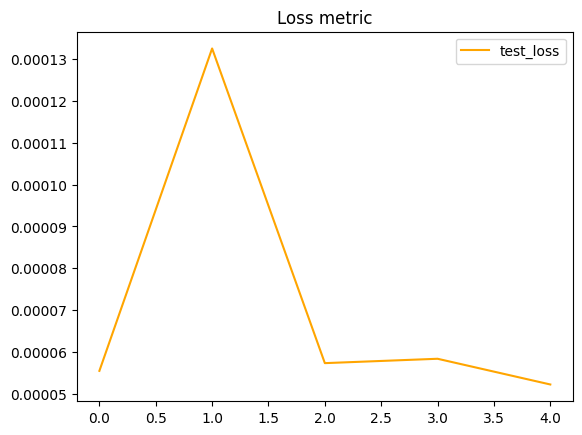

In [38]:
env.show_metrics(n_last=5, train=False, val=True)

## Clear memory

In [14]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()

In [13]:
env.model.cpu()
del env.model
import torch
torch.cuda.empty_cache()

In [6]:
def test():
    losses = []
    errors = []
    init_errors = []
    losses_dataset = []
    with torch.no_grad():
    
        for row in zip(*env.val_features_loaders + [env.val_target_loader]):
            data_features = list(row)
            data_target = data_features.pop()
            
            x = data_features[0][0]
            
            fft2 = torch.fft.fft2(x, norm="ortho")

            x_fft = torch.dstack([fft2.real, fft2.imag]).view(80, 80, 2).permute([2, 0, 1])
            
            outputs_fft = env.model(x_fft) #* 65.
            
            outputs_fft_complex = torch.complex(*outputs_fft)
            
            fft2_inv = torch.fft.ifft2(outputs_fft_complex, norm="ortho")
            outputs = fft2_inv.real
            ex_id = 0
            data_target = data_target[0]
            
            losses_dataset_step = torch.max(torch.abs(data_features[0][ex_id][0] - data_target[ex_id])).detach().tolist()
            losses_dataset.append(losses_dataset_step)
            
            init_error = torch.mean(torch.abs(data_features[0][ex_id][0] - data_target[ex_id]) / torch.abs(data_target[ex_id]))
            init_errors.append(init_error.detach().tolist())
            
            loss = torch.max(torch.abs(outputs - data_target[ex_id]))
            losses.append(loss.detach().tolist())
            # print(data_target[ex_id].size())
            
            
            error = torch.mean(torch.abs(outputs[ex_id] - data_target[ex_id]) / torch.abs(data_target[ex_id]))
            errors.append(error.detach().tolist())
            
            # for ex_id in range(env.val_batch_size):
            #     
            #     losses_dataset_step = torch.max(torch.abs(data_features[0][ex_id][0] - data_target[ex_id])).detach().tolist()
            #     losses_dataset.append(losses_dataset_step)
            #     
            #     init_error = torch.mean(torch.abs(data_features[0][ex_id][0] - data_target[ex_id]) / torch.abs(data_target[ex_id]))
            #     init_errors.append(init_error.detach().tolist())
            #     
            #     loss = torch.max(torch.abs(outputs[ex_id] - data_target[ex_id]))
            #     losses.append(loss.detach().tolist())
            #     # print(data_target[ex_id].size())
            #     
            #     
            #     error = torch.mean(torch.abs(outputs[ex_id] - data_target[ex_id]) / torch.abs(data_target[ex_id]))
            #     errors.append(error.detach().tolist())
                #print(outputs, data_target)
                
    print("Начальное среднее отклонение по значениям:", sum(losses_dataset) / len(losses_dataset))
    print("Текущее среднее отклонение по значениям:", sum(losses) / len(losses))
    
    print()
    print("Начальное максимальное отклонение по значениям:", max(losses_dataset))
    print("Текущее максимальное отклонение по значениям в векторе:", max(losses))
    
    print()
    print("Начальная средняя относительная ошибка:", sum(init_errors) / len(init_errors))
    print("Текущая средняя относительная ошибка:", sum(errors) / len(errors))
    print()
    print("Начальная максимальная относительная ошибка:", max(init_errors))
    print("Текущая максимальная относительная ошибка:", max(errors))
test()

Начальное среднее отклонение по значениям: 0.026016585528850555
Текущее среднее отклонение по значениям: 2.1138689294457436

Начальное максимальное отклонение по значениям: 0.045397281646728516
Текущее максимальное отклонение по значениям в векторе: 4.617318630218506

Начальная средняя относительная ошибка: 0.005001195095246658
Текущая средняя относительная ошибка: 1.8679515551775694

Начальная максимальная относительная ошибка: 0.005064061377197504
Текущая максимальная относительная ошибка: 7.108710765838623
